# Solving the Finite Symmetric Well using the Shooting Method
### Erik S. Sorensen, Physics & Astronomy, McMaster University,  October 2, 2019
#### Last Edit: Pat Clancy - October 13, 2023

In this notebook we will be solving the **finite** symmetric well using the shooting method. This is just a minor modification of the method we used to study the **infinite** potential well in Exercise 1. That is, we shall be looking for solutions to the **stationary** Schr&ouml;dinger equation. The potential does not need to be a square well but it is crucial that it is *symmetric*. To make the potential symmetric we define the potential from $-a$ to $a$. Outside this range we assume the potential is **zero**. Furthermore we shall take $\hbar=m=1$. Let's begin by importing some things we need.

In [2]:
import scipy.integrate
from pylab import *
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import numpy as np

Now let's define the potential of our well. **Outside** the well set the potential to 0 while **inside** we set it to $V_0$ (for now) which we will define later. The potential well is therefore *finite*, unlike the case of the infinite well where we set the potential to a very large value outside the well. 

__ACTION__: Fill in the code below to set up an appropriate function for the potential using the *if* and *else* commands:

In [15]:
def V(x):
    global a 
    
    if abs(x) > a:
        return 0
    else:
        return V0
    
    

We will be using the same dual array method that we employed for the infinite well. Therefore, we can use the same D1D2 function that you came across in the last notebook. This function assumes that the value of $E$ is defined elsewhere and it looks as follows:

In [16]:
def D1D2(psi, x):
    D1 = psi[1]
    D2 = 2.0*(V(x) - E)*psi[0]
    return array([D1, D2])

We use the same method for integrating as we did for the Infinite Well. That is, we need a function that can integrate $\psi(x)$ and $\psi'(x)$ as 2 first order equations given some initial guess at a left-most point $x_{left}$. The routine will integrate from the left to the right-most end point $x_{right}$.  Python has utilities for doing this and the one we shall be using is called odeint from a module called scipy. We set it up so that if the function is given a value of $E$ it will return a single value which is $\psi(x_{right})$, where $x_{right}$ is the right-most end point of the integration. Later we shall specify what $x_{right}$ is. The python way of getting the right-most value of an [N,2] array is psi[-1,0], where the negative value means counting from the end. As mentioned, psi[:,0] contains the values of $\psi(x)$ and psi[:,1] contains the values of $\psi'(x)$.

**There is a new feature here** compared to what we did for the Infinite Well and that is a normalization of the result. We assume that we only calculate *half* of the wave-function (the 'left' side of it), and if we are going to sum the squares of that we need to multiply by 2 to get the entire integral of the square of the wavefunction. Since we square the wavefunction it does not matter if it is even or odd. Note that we normalize both the $\psi(x)$ and $\psi'(x)$.

In [41]:
def Wave_function(energy):
    global psi
    global E
    E = energy                #We need this so as to pass it to DD
    psi = odeint(D1D2, psi0, x)
    psi = psi/sqrt(h*2.*np.sum(np.square(psi[:,0])))
    return psi[-1,0]

### The shooting method

As in Exercise 1, the shooting method is pretty straightforward. First we guess an energy $E$. Then we integrate from **outside** the left wall of the well, $x_{left}=-b$, where we can assume that $\psi(x_{left}=-b)=0$ and $\psi'(x_{left}=-b)\neq 0$. We integrate up to $x_{right}=0$ (the mid-point of the well) and if the integrated function $\psi(x=0)=0$ then we guessed right and the energy $E$ is a solution. Note that this **only** works because the well is symmetric around zero, which means that the solutions, $\psi(x)$, will be either even or odd functions. If we require $\psi(x=0)=0$ we obtain the odd solutions. If instead we want the even solutions then we should require $\psi'(x=0)=0$.

The second fact that we need is that each subsequent solution will have **one more node**. This means that if we plot $\psi(x=0)$ (or $\psi'(x=0)$) **as a function of** $E$ it will change sign every time we have an energy $E$ that is a solution. Let's see how that works: We set up the calculation by taking a number of discrete points on the x-axis and a number of discrete values of $E$, stored in *en*, between $E_{bottom}$ and $E_{max}$. This sets the energy interval where we shall be looking for solutions. Note that we do not allow $E_{max}$ to go all the way up to the rim of the potential at $0$ since we cannot handle scattering states with this approach. We start by focusing on the odd solutions which should have $\psi(x=0)=0$. For each value of $E$ in *en* we then integrate up to find $\psi(x=0)$.

The new feature here compared to the Infinite Well is that we have to be a little careful about how we start the integration. Since the wave-function can be non-zero outside of the well we start the integration at $x_{left}=-b$. The wavefunction will grow at an exponential rate in the direction of integration until it reaches the well. While we set $\psi(x_{left}=-b)=0$ it makes sense to set $\psi'(x_{left}=-b)$ equal to a reasonable estimate of what we might assume it is. Since the distance to the well is $(b-a)$ and since the potential is constant $V(x)=0$ it should be relatively easy to estimate. On the other hand we don't want $\psi'(x=-b)$ to be too small so we put in a limit that it should not go below 0.00000001. This is necessary, because if we start the *odeint* with values that are too small we might just get numerical noise. Similarly, if we set $\psi'(x=-b)$ at too large a value then $\psi$ might reach too large a value for the computer to handle before we reach the well. We need to do this for each energy *e1* we consider so we put our new estimate of *psi0* inside the *for* loop.


In [42]:
N = 10000                   # number of discrete points on the x-axis
a = 1                       # Set the width of the well
b = 2*a                     # Set the starting point outside the well for integrating
h = b/(N-1)                 # Set the spacing between points on the x-axis
V0 = -10.0                  # Set the bottom of the well
E = 0                       # initialize the global variable E
psi = np.zeros([N,2])       # Wave function values and its derivative (psi and psi')
x = linspace(-b, 0, N)      # the points on the x-axis between left wall of the well and x=0
Emax = -1
Ebottom = V0                # let us only look for solutions between Ebottom and Emax
en = linspace(Ebottom, Emax, 1000) # A number of discrete energies where we will calculate psi(x=0)
psi_b = []                  # vector of wave function at x = 0 for all of the energies in en
for e1 in en:
    kappa = sqrt(-2*e1)
    psiprime=kappa*np.exp(-kappa*abs(b-a))
    psiprime=max(psiprime,0.00000001)
    psi0 = array([0,psiprime])
    psi_b.append(Wave_function(e1))     # Determine psi(x=0) for every e1 in en

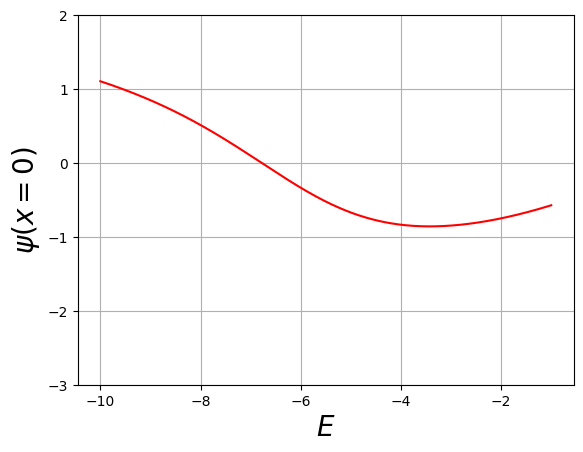

In [43]:
plt.plot(en, psi_b, 'r-')
plt.xlabel(r'$E$',size=20)
plt.ylabel(r'$\psi(x=0)$',size=20)
plt.grid(True)
plt.ylim(-3,2)
plt.show()

### Finding precise solutions

It is a bit hard to read of the exact values of the zeroes on the figure above so we are going to use a python routine, brentq, that will find them more precisely. The routine locates two subsequent values in the array psi_b where there is a sign change and then uses extrapolation techniques to find more precise values for the value of E that gives us a $\psi(x=0)=0$. This is unchanged from what we did for the Infinite Well.

In [44]:
def find_all_zeroes(x,y):
    all_zeroes = []
    s = sign(y)
    for i in range(len(y)-1):
        if s[i]+s[i+1] == 0:
            zero = brentq(Wave_function, x[i], x[i+1])
            all_zeroes.append(zero)
    return all_zeroes

We can now determine all the zeroes in the range up to $E_{max}$ and print them out

In [45]:
E_zeroes = find_all_zeroes(en, psi_b)   # now find the precise energies where psi(x=0) = 0 
print( "Energies for the bound states are: ")
for E in E_zeroes:
        print( '%11.7f' % E)
        

Energies for the bound states are: 
 -6.7778775


### Question 1

We start by setting $a=10$ and $V_0=-10$. We hope that this is reasonably close to a wide, deep well. Focusing on the odd solutions, compare the first 3 values you get to the approximate values that we derived in class. What is the relative error? Set $a=2$ $V_0=-10$ and focus on the first *even* solution. Compare your result to the expression from Section 2.6 in Griffiths.

In class, the wide and deep well approached the infinite square well solutions. So we can estimate the first 3 values by using the formula: 
En + V0 ~= n<sup>2</sup>pi<sup>2</sup>hbar<sup>2</sup>/(2m*(2a)^2)
 

In [ ]:
hbar = 1
m = 1
a = 10
V0 = -10
def griff(n):
    return (n*pi*hbar)**2/(2*m*(2*a)**2) + V0
for n in range(1,4):
    n0 = (2*n-1)
    print ('from notes:', griff(n0), 'from code:', E_zeroes[n-1], 'error:', abs(((n0)*pi*hbar)**2/(2*m*(2*a)**2) + V0 - E_zeroes[n-1])/E_zeroes[n-1])


In [ ]:
print('even sol:')
a = 2
n = 1
print ('from notes:', ((n)*pi*hbar)**2/(2*m*(2*a)**2) + V0, 'from code:', E_zeroes[n-1], 'error:', abs(((n)*pi*hbar)**2/(2*m*(2*a)**2) + V0 - E_zeroes[n-1])/E_zeroes[n-1])

With the precise energy values determined we can look at the wavefunctions. Since in this case we want the wavefunction not only in the well but also outside of it, we set the x-axis to be from -b to 0. You might ask why we don't set it to go from -b to b. The problem with that is that it won't really work when $x>a$ because routines like *odeint* struggle to work if we choose a direction where the solution we're looking for is **exponentially decreasing**. At some point *odeint* will instead start to pick up the solutions to Schr&ouml;dinger's equation that are **exponentially increasing**. Mathematically that is a solution to the differential equation as well, but it is unphysical, so we throw it away. Unfortunately, the computer does not know about that. On the other hand this is pretty easy to fix since we know that the solutions are either even or odd. So, we can simply copy the solution we have for $x<0$, reverse it, and use it for $x>0$. That explains the extra lines with *psil*, *psir* and *psilr*. Reversing the elements in an array is easy to do by using *psil[N-1,0,-1]*, where we skip the last element of *psil* since that corresponds to $x=0$. Also note that, when we look at the odd solutions we have to put in a minus sign when we copy over *psil* to form *psir*. The final result is *psilr* which goes all the way from -b to b.

In [ ]:
x = linspace(-b, 0, N)
xall =linspace(-b,b,2*N-1)
h=b/(N-1)
for E in E_zeroes[0:1]:
        Wave_function(E)
        psil = psi[:,0]
        psir = -psil[N-1:0:-1]
        psilr = np.append(psil,psir)
        psilr=psilr/sqrt(h*np.sum(np.square(psilr)))
        plt.plot(xall, psilr, label="E = %.2f"%E)

#ignore this shit yo        
#xstuff = linspace(-1.5,-1,1000)        
#def func(x):
#    return ((0.2/0.5)*x)+0.6
#plt.plot(xstuff,func(xstuff),label="V(x)")

plt.xlabel(r'$x$',size=20)
plt.ylabel(r'$\psi(x)$',size=20)
plt.legend()
plt.grid(True)
plt.show()

### Question 2

Now let us look at a well that is much more narrow well by setting a=1. Since the well is quite narrow we might expect significant 'leaking' of the wavefunction outside the well. Therefore, set b=3a. Let us focus on the first odd state. We want to determine $\int_{-b}^{-a}|\psi(x)|^2dx+\int_a^b|\psi(x)|^2dx$, the probability for being outside the well. 
Since we assume that the entire normalized wavefunction between $x=-b$ and $x=b$ is in *psilr* we can do this easily by defining a new function which takes the value *psilr* outside the well (where *abs(xall)>0*), and a value of zero inside the well. This is the first line below. Complete the single line necessary to actually determine the desired probability. What you need is similar to what is done above.

In [ ]:
psioutside=np.where(abs(xall)>a,psilr,0)
proba = sum((psioutside**2)*h)   
print('Probability outside well: %11.7f' % proba)